In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Model, Layer, layers, optimizers, losses, metrics, regularizers, callbacks

2024-05-19 12:53:11.732474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 12:53:12.241236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 12:53:13.788540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [4]:
from config import Config
from utils.data_loader import DataLoader

In [5]:
train_df = DataLoader().load_train_data()

In [6]:
train_df

,user_id,item_id,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


In [7]:
val_df = DataLoader().load_val_data()

In [8]:
val_df

,user_id,item_id,rating
0,655,911,2
1,200,88,4
2,763,607,4
3,500,714,2
4,690,163,3
...,...,...,...
19995,932,38,2
19996,154,874,3
19997,527,425,4
19998,464,333,4


In [49]:
x_train, x_test, y_train, y_test = train_df.values, val_df.values, train_df['rating'].values, val_df['rating'].values

In [50]:
x_train.shape

(80000, 3)

In [51]:
class MinMaxNormalization(Layer):
    
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        scalar = lambda x: ((x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))) * (max_val - min_val) + min_val
        self.lambda_layer = layers.Lambda(scalar)
        
    def call(self, inputs):
        return self.lambda_layer(inputs)

In [55]:
class DeepMF(Model):
    
    def __init__(
        self,
        latent_dim:int = 5, 
        num_users:int = Config.Vars.NUM_USERS,
        num_items:int = Config.Vars.NUM_ITEMS,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_users = num_users
        self.num_items = num_items
        self.user_embedding = layers.Embedding(self.num_users + 1, self.latent_dim, name='user_embedding')
        self.user_flatten = layers.Flatten(name='user_flatten')
        # self.user_output = layers.Identity(name='user_output')
        self.item_embedding = layers.Embedding(self.num_items + 1, self.latent_dim, name='item_embedding')
        self.item_flatten = layers.Flatten(name='item_flatten')
        # self.item_output = layers.Identity(name='item_output')
        self.dot = layers.Dot(axes=1, name='dot')
        self.concatenate = layers.Concatenate(axis=1, name='concatenate')
        self.norm = MinMaxNormalization(min_val=0, max_val=5, name='normalize')
    
    def call(self, inputs):
        user_id, item_id, ratings = inputs[0], inputs[1], inputs[2]
        user_emb = self.user_embedding(user_id)
        user_emb = self.user_flatten(user_emb)
        item_emb = self.item_embedding(item_id)
        item_emb = self.item_flatten(item_emb)
        rating_vec = self.dot([user_emb, item_emb])
        embeddings = self.concatenate([user_emb, item_emb])
        norm_ratings = self.norm(ratings)
        return rating_vec, embeddings, norm_ratings
    
    def train_step(self, data):
        
        inputs, output = data
        
        with tf.GradientTape() as tape:
            rating_vec, _, _ = self.call(inputs)
            loss = self.compute_loss(y=output, y_pred=rating_vec)
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            'mse_loss': loss,
            'r2_score': self.compute_metrics(x=inputs[0], y=output, y_pred=rating_vec)['r2_score']
        }
    
    def summary(self):
        model = self.build_graph()
        return model.summary()
    
    def build_graph(self):
        x = layers.Input(shape=[2])
        return Model(inputs=x, outputs=self.call(x))

In [56]:
deepmf = DeepMF()
deepmf.compile(
    optimizer=optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.R2Score()]
)

In [58]:
deepmf.fit(
    [x_train[:, 0], x_train[:, 1], x_train[:, 2]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1], x_test[:, 2]], y_test),
    epochs=10,
    batch_size=32,
    validation_freq=3
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - mse_loss: 1.1161 - r2_score: 0.0879 - loss: 0.0000e+00
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 769us/step - mse_loss: 0.9836 - r2_score: 0.2102 - loss: 0.0000e+00
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - mse_loss: 0.9303 - r2_score: 0.2648 - loss: 0.0000e+00 - val_loss: 0.9471 - val_r2_score: 0.2509
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - mse_loss: 0.9046 - r2_score: 0.2911 - loss: 0.0000e+00
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - mse_loss: 0.8905 - r2_score: 0.2980 - loss: 0.0000e+00
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - mse_loss: 0.8806 - r2_score: 0.3114 - loss: 0.0000e+00 - val_loss: 0.9118 - val_r2_score: 0.2789
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - mse_loss: 0.8730 - r2_score: 0.3198 - loss: 0.0000e+00
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step - mse_loss: 0.8667 - r2_score: 0.3192 - loss: 0.0000e+00
Epoch 9/10
2500/25

In [59]:
deepmf.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (2)               │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (2)               │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (2, 5)            │      4,720 │ get_item_8[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (2, 5)            │      8,415 │ get_item_9[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (2, 5)            │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (2, 5)            │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (2)               │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (2, 1)            │          0 │ user_flatten[0][… │
│                     │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (2, 10)           │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ item_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize           │ (2)               │          0 │ get_item_10[0][0] │
│ (MinMaxNormalizati… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
deepmf.predict([x_test[:, 0], x_test[:, 1]])

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[2.0928314],
       [4.1407433],
       [4.0448985],
       ...,
       [3.7896616],
       [3.956799 ],
       [3.7377539]], dtype=float32)

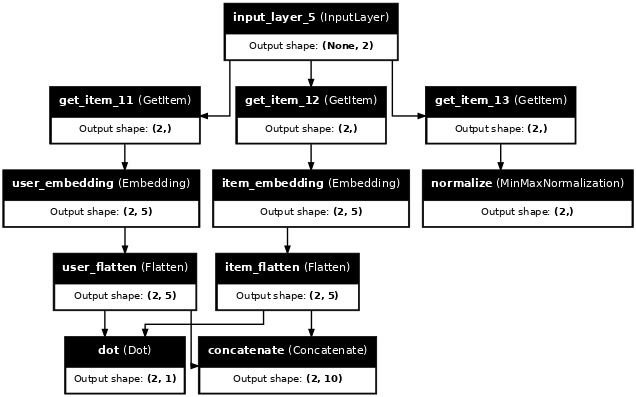

In [60]:
keras.utils.plot_model(
    deepmf.build_graph(),
    show_shapes=True,
    show_layer_names=True,
    dpi=50
)

In [ ]:
class GAN(Model):
    
    def __init__(
        self,
        generator: Model,
        discrimator: Model,
        latent_dim: int = 100,
        **kwargs
    ):
        super(GAN, self).__init__(**kwargs)
        self.generator = generator
        self.discrimator = discrimator
        self.latent_dim = latent_dim
    
    def call(self, inputs, training=False):
        noise_vec, input_tensor = inputs
        
        gen_tensor = self.generator(noise_vec, training=True)
        
        real_output = self.discrimator(input_tensor, training=True)
        gen_output = self.discrimator(gen_tensor, training=True)
        
        return gen_tensor, real_output, gen_output
    
    def compile(
        self,
        gen_optimizer: keras.Optimizer,
        disc_optimizer: keras.Optimizer,
        **kwargs
    ):
        super(GAN, self).compile(**kwargs)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
    
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        _, real_output, gen_output = y_pred
        
        gen_loss = losses.binary_crossentropy(tf.ones_like(gen_output), gen_output)
        disc_loss = losses.binary_crossentropy(tf.ones_like(real_output), real_output) + losses.binary_crossentropy(tf.zeros_like(gen_output), gen_output)
        
        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }
    
    def train_step(self, inputs):
        
        noise_vec = tf.random.normal((tf.shape(inputs)[0], self.latent_dim))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            _, real_output, gen_output = self.call(inputs=(noise_vec, inputs), training=True)
            loss = self.compute_loss(y=[inputs, real_output, gen_output])
        
        gen_grads = gen_tape.gradient(loss['gen_loss'], self.generator.trainable_weights)
        disc_grads = disc_tape.gradient(loss['disc_loss'], self.discrimator.trainable_weights)
        
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrimator.trainable_weights))
        
        return {
            'gen_loss': loss['gen_loss'],
            'disc_loss': loss['disc_loss']
        }
    
    def predict(self, x):
        return self.generator(x)
    
    def summary(self):
        model = self.build_graph()
        return model.summary()
    
    def build_graph(self):
        if isinstance(self.discrimator, keras.src.models.Functional):
            input_shape = self.discrimator.layers[1].input.shape[1:]
        else:
            input_shape = self.discrimator.layers[0].input.shape[1:]
        
        input_tensor = layers.Input(shape=input_shape)
        noise_vec = layers.Input(shape=(self.latent_dim,))
        
        return Model(inputs=[noise_vec, input_tensor], outputs=self.call([noise_vec, input_tensor]))

In [23]:
def build_generator():
        latent_dim = 10
        model = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(units=latent_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(20),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(rate=0.2),
            layers.Dense(units=latent_dim * 2 + 1),
        ])
        
        return model

In [24]:
def build_discriminator():
        latent_dim = 10
        model = keras.Sequential([
            layers.Input(shape=(latent_dim * 2 + 1, )),
            layers.Dense(units=latent_dim * 2 + 1),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(units=1),
            layers.Activation('sigmoid')
        ])
        
        return model